In [2]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.8.0+cu128
2.8.0+cu128
cuda


In [3]:
import IPython
import matplotlib.pyplot as plt

In [4]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)


def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]


text = "Hi! My name is Kim Damin!"
print(text_to_sequence(text))

[19, 20, 2, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11, 22, 20, 24, 11, 15, 12, 24, 20, 25, 2]


In [5]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hi! My name is Kim Damin!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 20,  2, 11, 24, 36, 11, 25, 12, 24, 16, 11, 20, 30, 11, 22, 20, 24,
         11, 15, 12, 24, 20, 25,  2]])
tensor([25], dtype=torch.int32)


In [6]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'i', '!', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'k', 'i', 'm', ' ', 'd', 'a', 'm', 'i', 'n', '!']


In [8]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hi! My name is Kim Damin!"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 32,  2, 11, 66, 32, 11, 67, 48, 66, 11, 55, 94, 11, 64, 55, 66, 11,
         38, 48, 66, 55, 67,  2]])
tensor([24], dtype=torch.int32)


In [9]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AY', '!', ' ', 'M', 'AY', ' ', 'N', 'EY', 'M', ' ', 'IH', 'Z', ' ', 'K', 'IH', 'M', ' ', 'D', 'EY', 'M', 'IH', 'N', '!']


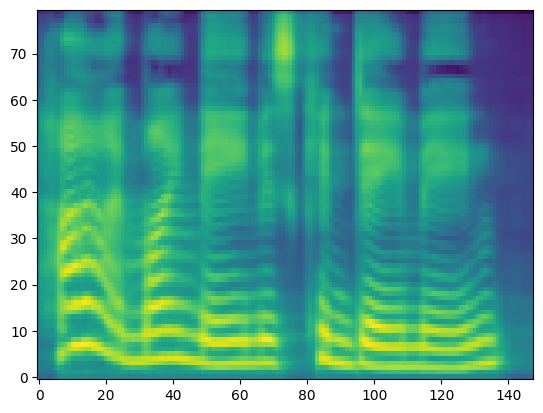

In [11]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hi! My name is Kim Damin!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 147])
torch.Size([80, 145])
torch.Size([80, 148])


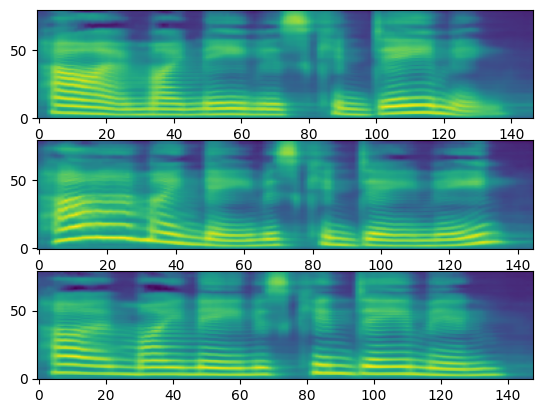

In [12]:
def plot():
    fig, ax = plt.subplots(3, 1)
    for i in range(3):
        with torch.inference_mode():
            spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
        print(spec[0].shape)
        ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")


plot()

## WaveRNN Vocoder

In [13]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hi! My name is Kim Damin!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to C:\Users\user/.cache\torch\hub\checkpoints\wavernn_10k_epochs_8bits_ljspeech.pth


100%|██████████| 16.7M/16.7M [00:00<00:00, 25.2MB/s]


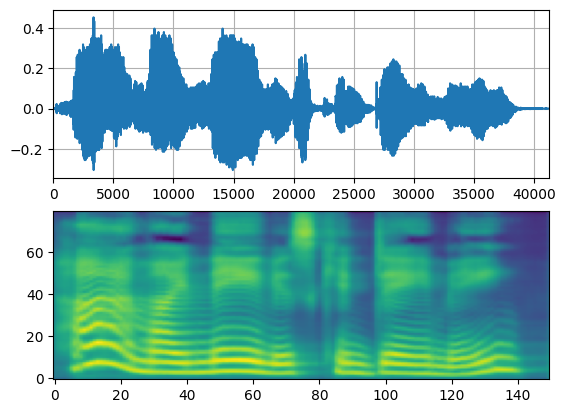

In [14]:
def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)


plot(waveforms, spec, vocoder.sample_rate)

## Griffin-Lim Vocoder

In [15]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to C:\Users\user/.cache\torch\hub\checkpoints\tacotron2_english_phonemes_1500_epochs_ljspeech.pth


100%|██████████| 107M/107M [00:09<00:00, 12.5MB/s] 


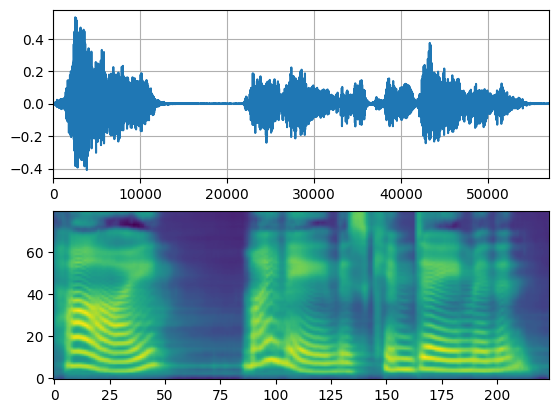

In [16]:
plot(waveforms, spec, vocoder.sample_rate)

## Waveglow Vocoder

In [17]:
# Workaround to load model mapped on GPU
# https://stackoverflow.com/a/61840832
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to C:\Users\user/.cache\torch\hub\torchhub.zip


C:\Users\user/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\user/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth" to C:\Users\user/.cache\torch\hub\checkpoints\nvidia_waveglowpyt_fp32_20190306.pth


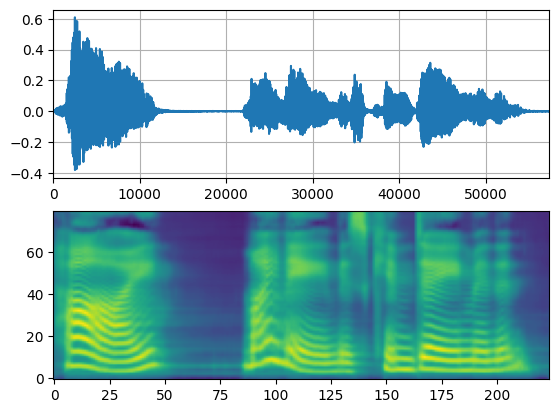

In [18]:
plot(waveforms, spec, 22050)